参考链接：https://jalammar.github.io/illustrated-bert/    
    https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/    
        http://jalammar.github.io/illustrated-transformer/

# `BERT`基本原理

`BERT:Bidirectional Encoder Representations from Transformers`
## BERT架构
- 自编码语言模型，模型结构为 `Transformer` 的**编码器**；由12层或更多的`EncoderLayer`组成
<img src="../images/bert架构.png" width="80%">
-----------------                  
## BERT预训练                  
用两个任务来预训练该模型，如下图 (a) 所示
![bert-tasks](../images/bert-tasks.png)
- `MaskLM`，输入的话中随机选择一些词，用特殊符号 `[MASK]` 替换，让模型预测这些词
    - 训练过程类似“完形填空”。在一句话中随机选择 `15%` 的单词用于预测，其中 `80%` 情况下采用特殊符号 `[MASK]` 替换，`10%` 情况采用任意词替换，`10%` 的情况下保持原词汇不变
    - 之所以这样做：在后续微调任务中语句中并不会出现 `[MASK]` 标记
    - 预测一个词汇时，模型并不知道输入对应位置的词汇是否为正确的词汇（`10%`概率），这就迫使模型更多地依赖于上下文信息去预测词汇，并且赋予了模型一定的纠错能力。
    - 因此模型可能需要更多的训练步骤来收敛    
             
             
- `Next Sentence Prediction`，输入的两句话，让模型判断是否是连续的两句话，让模型学习连续的文本片段之间的关系
    - 类似于“连句任务”，给定一篇文章中的两句话，判断第二句话在文本中是否紧跟在第一句话之后
    - 文本语料库中随机选择 `50%` 的正确语句对和 `50%` 的错误语句对进行训练


  
  
- 两个任务联合训练，使模型输出的每个字 / 词的向量表示都能尽可能全面、准确地刻画输入文本（单句或语句对）的整体信息，为后续的微调任务提供更好的模型参数初始值。

----------------------------------------
## BERT微调  
如上图 (b) 所示，预训练好的模型，对新的句子进行编码，然后取 `[CLS]`对应的输出向量，进行分类任务；或最后的几个输出向量，进行其它任务

------------------------------
## BERT优缺点
- 相较于 `RNN、LSTM` 可以实现并发训练，同时提取词在句子中的关系特征，在不同的层次提取关系特征，进而更全面反映句子语义。
- 相较于 `word2vec`，其又能根据句子上下文获取词义，从而避免歧义出现。
- 模型参数太多，而且模型太大，少量数据训练时，容易过拟合。

# BERT用于分类任务
- 因为bert模型的词汇在预训练时已经固定，所以<span class="burk">必须使用bert模型自带的分词器对文本处理</span>
- <span class="burk">文本必须处理成满足bert模型输入的格式要求</span>，添加特殊的`token:[CLS],[SEP],[PAD]`

## 语料
[`COLA(The Corpus of Linguistic Acceptability)`](https://nyu-mll.github.io/CoLA/)  ,句子在语法上是否可接受`(0=unacceptable, 1=acceptable)`

In [16]:
import pandas as pd
df = pd.read_csv("../datasets/cola_public/raw/in_domain_train.tsv",
                 delimiter='\t',
                 header=None,
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

print('number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(5)

number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
6207,c_13,1,NaN,What did Jean think was likely to have been st...
7794,ad03,1,NaN,Gilgamesh has been fighting the dragon.
6575,g_81,0,*,To which city and which conference did Bill go...
3517,ks08,1,NaN,He washed us.
4141,ks08,1,NaN,The characters in Shakespeare's Twelfth Night ...


In [17]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
6029,The cake was been eating.,0
7106,Kim gave a dollar to Bobbie and a dime into hi...,0
6152,Louis was sent a book to.,0
5447,He's reliable enough a man.,0
1769,Willy is taller than Bill is strong and.,0


In [18]:
sentences = df.sentence.values
labels = df.label.values

## 分词

In [19]:
from transformers import BertTokenizer
print("Loading BERT tokenizer...")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',  # 按模型名称载入
#                                           do_lower_case=True)
# with open('../models/bert/vocabulary.txt', 'w') as f:
#     for token in tokenizer.vocab.keys():
#         f.write(token + '\n')

tokenizer = BertTokenizer.from_pretrained(
    '../models/bert/vocabulary.txt',  # 从保存有词汇表的本地文件载入
    do_lower_case=True)

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated


Loading BERT tokenizer...


In [20]:
print("Original:  ", sentences[0])
print("Tokenized:  ", tokenizer.tokenize(sentences[0]))
print("Token IDS:  ",
      tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:   Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:   ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDS:   [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


## 满足`BERT`模型的输入格式

**特殊标记**:
- 每个句子的结尾，添加上`[SEP]`标记：用于决定两个句子的关系，如是否是连续的两个句子
- 分类任务，在每个句子的开端添加`[CLS]`标记；模型输入的矩阵，只有第一个向量用于分类

**句子长度和遮档**
- 语料不同句子长度相差很大，需要所有句子填充或截断到相同的长度；且`BERT`模型，最长512个标记
- 填充是添加标记`[PAD]`，在词汇表中索引为 0 
    - `[CLS] I like to draw [SEP] [PAD] [PAD]`
    
- 遮挡是 0 和 1 的序列，1 表示单词，0 表示填充；填充的多少对模型的速度和精度会有影响    

In [21]:
# 文本向量化

input_ids = []

for sent in sentences:
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens=True,  # 添加特殊符号
    )
    input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Tokenized:  ", tokenizer.tokenize(sentences[0]))
print("Token IDs: ", input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:   ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]


In [22]:
MAX_LEN = max([len(sen) for sen in input_ids])
print("Max sentence length: ", MAX_LEN)

Mac sentence length:  47


In [23]:
# 填充为相同长度

from tensorflow.keras.preprocessing.sequence import pad_sequences

print("Padding token: {:}, ID: {:}".format(tokenizer.pad_token,
                                           tokenizer.pad_token_id))
input_ids = pad_sequences(input_ids,
                          maxlen=MAX_LEN,
                          dtype='long',
                          value=0,
                          truncating="post",
                          padding='post')
input_ids.shape

Padding token: [PAD], ID: 0


(8551, 47)

In [24]:
# 填充对应的mask

attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [25]:
# 拆分为测试集和训练集

from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, random_state=2008, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                        labels,
                                                        random_state=2008,
                                                        test_size=0.1)

In [26]:
# 转化为 PyTorch 数据格式
import torch

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [27]:
# 创建数据管道

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,
                          sampler=train_sampler,
                          batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=batch_size)

## 创建并训练分类模型
`huggingface`提供的接口：

- BertModel
- BertForPreTraining
- BertForMaskedLM
- BertForNextSentencePrediction
- **BertForSequenceClassification** 
- BertForTokenClassification
- BertForQuestionAnswering    
  
将模型`"bert-base-uncased": "https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin"`,  
模型词汇表`"bert-base-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt",`,  
模型配置`"bert-base-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json",`三个文件下载到本地，文件夹命名为`"bert-base-uncased"`, 然后更改文件名，删除名字中的前缀`"bert-base-uncased"`

In [31]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
import os

# 载入 bert 预训练模型

path = os.path.abspath("../../H/models/huggingface/bert-base-uncased/")

model = BertForSequenceClassification.from_pretrained(
    # "bert-base-uncased",   # 按名称载入模型
    path,  # 本地文件载入
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [32]:
# 模型参数详情

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(
    len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [36]:
# 优化器
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)


# 学习率规划
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

In [38]:

# 预测精度
import numpy as np


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# 格式化时间显示
import time
import datetime


def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [42]:
# 训练并验证模型

import random

# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(
                step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy / nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:05.
  Batch    80  of    241.    Elapsed: 0:00:09.
  Batch   120  of    241.    Elapsed: 0:00:14.
  Batch   160  of    241.    Elapsed: 0:00:19.
  Batch   200  of    241.    Elapsed: 0:00:23.
  Batch   240  of    241.    Elapsed: 0:00:28.

  Average training loss: 0.17
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:05.
  Batch    80  of    241.    Elapsed: 0:00:09.
  Batch   120  of    241.    Elapsed: 0:00:14.
  Batch   160  of    241.    Elapsed: 0:00:19.
  Batch   200  of    241.    Elapsed: 0:00:23.
  Batch   240  of    241.    Elapsed: 0:00:28.

  Average training loss: 0.20
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:05.
  

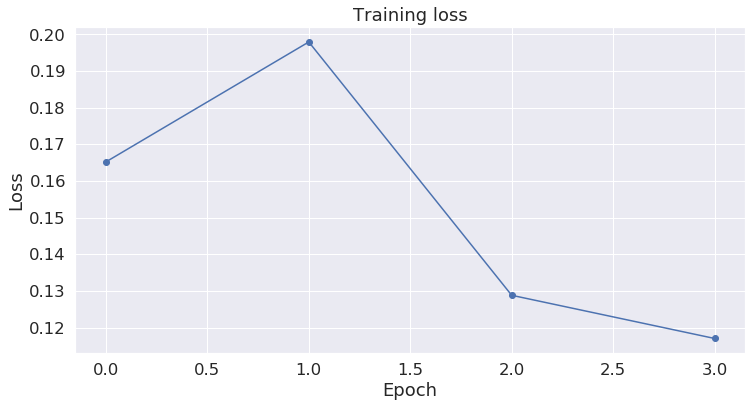

In [44]:
# 训练过程的损失变化

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## 评估模型

In [45]:
# 测试集数据处理

import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("../datasets/cola_public//raw/out_of_domain_dev.tsv",
                 delimiter='\t',
                 header=None,
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# 文本预处理
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
        sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    )

    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids,
                          maxlen=MAX_LEN,
                          dtype="long",
                          truncating="post",
                          padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks,
                                prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data,
                                   sampler=prediction_sampler,
                                   batch_size=batch_size)

Number of test sentences: 516



In [46]:
# 在测试集上进行预测

print('Predicting labels for {:,} test sentences...'.format(
    len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Predict
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [47]:
print('Positive samples: %d of %d (%.2f%%)' %
      (df.label.sum(), len(df.label),
       (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [49]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0"
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
    matthews_set.append(matthews)

# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)



MCC: 0.524


>Matthews相关系数，用于度量二分类的质量。它会考虑TP/FP/TN/FP的情况，通常被认为是一个balanced的度量 ，可以用于那些有着不同size的分类中。MCC本质上是一个介于［－1，+1］之间的相关系数值。相关系数为+1，表示是一个完美的预测，0表示是一个平均随机预测（average random prediction），而-1表示是一个逆预测（inverse prediction）。这种统计方法也被称为：phi coefficient。   

$$MCC = \frac{tp \times tn - fp \times fn}{\sqrt{(tp + fp)(tp + fn)(tn + fp)(tn + fn)}}.$$

# BERT用于问答
给定`question`文本和包含该问题答案的对应的`answer_text`文本，从中找出`question`的答案

In [5]:
import torch

from transformers import BertForQuestionAnswering, BertTokenizer

model_path = "../../H/models/huggingface/bert-large-uncased-whole-word-masking-\
finetuned-squad/"
tokenizer = BertTokenizer.from_pretrained(model_path + "vocab.txt")
model = BertForQuestionAnswering.from_pretrained(model_path)

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated


In [11]:
question = "How many parameters does BERT-large have?"
answer_text = "BERT-large is really big...it has 24-layers and an embedding size \
of 1024, for a total of 340M parameters!"

In [12]:
input_ids = tokenizer.encode(question, answer_text)
print("The input has a total of {:} tokens.".format(len(input_ids)))

The input has a total of 44 tokens.


In [13]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)
for token, id in zip(tokens, input_ids):
    print("{:<12} {:>6,}".format(token, id))

[CLS]           101
how           2,129
many          2,116
parameters   11,709
does          2,515
bert         14,324
-             1,011
large         2,312
have          2,031
?             1,029
[SEP]           102
bert         14,324
-             1,011
large         2,312
is            2,003
really        2,428
big           2,502
.             1,012
.             1,012
.             1,012
it            2,009
has           2,038
24            2,484
-             1,011
layers        9,014
and           1,998
an            2,019
em            7,861
##bed         8,270
##ding        4,667
size          2,946
of            1,997
102           9,402
##4           2,549
,             1,010
for           2,005
a             1,037
total         2,561
of            1,997
340          16,029
##m           2,213
parameters   11,709
!               999
[SEP]           102


In [14]:
# segment mask

sep_index = input_ids.index(tokenizer.sep_token_id)

num_seg_a = sep_index + 1
num_seg_b = len(input_ids) - num_seg_a

segment_ids = [0] * num_seg_a + [1] * num_seg_b

assert len(segment_ids) == len(input_ids)

In [17]:
# 输入为一维，即无批数据维度时，不需要 pad 

start_scores, end_scores = model(torch.tensor([input_ids]),
                                 token_type_ids=torch.tensor([segment_ids]))
start_scores.shape, end_scores.shape

(torch.Size([1, 44]), torch.Size([1, 44]))

In [18]:
# 选择策略，不仅仅：是单个向量中最大的
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)
answer = " ".join(tokens[answer_start:answer_end + 1])
print("Answer: " + answer)

Answer: 340 ##m


In [19]:
# 将 子词 重新组合成 单词
answer = tokens[answer_start]
for i in range(answer_start + 1, answer_end + 1):
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    else:
        anser += " " + tokens[i]
print("Answer: " + answer)    

Answer: 340m


<function matplotlib.pyplot.show(*args, **kw)>

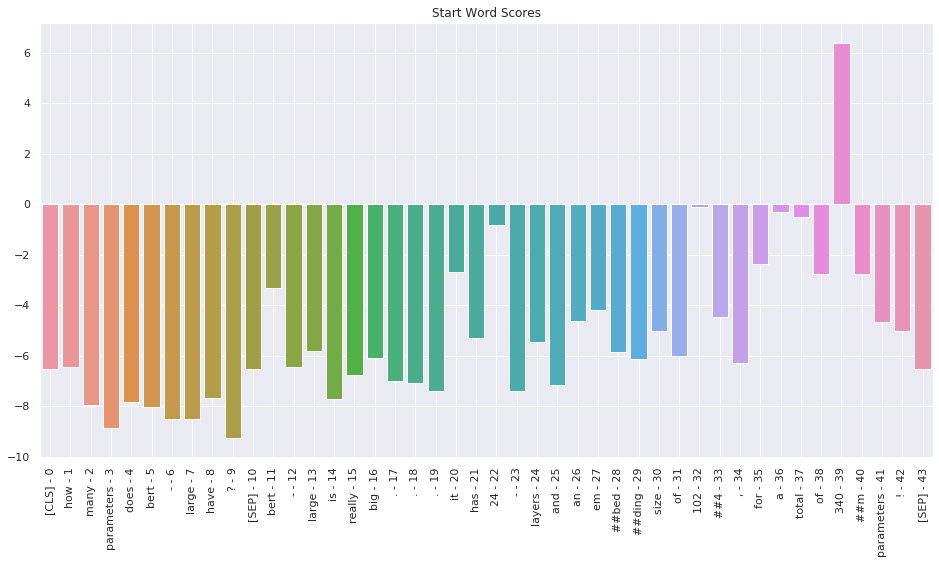

In [28]:
# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (16, 8)

# 权重分布
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# 对应的标签
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append("{:} - {:}".format(token, i))

# 可视化权重分布
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
ax.grid(True)
plt.title("Start Word Scores")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

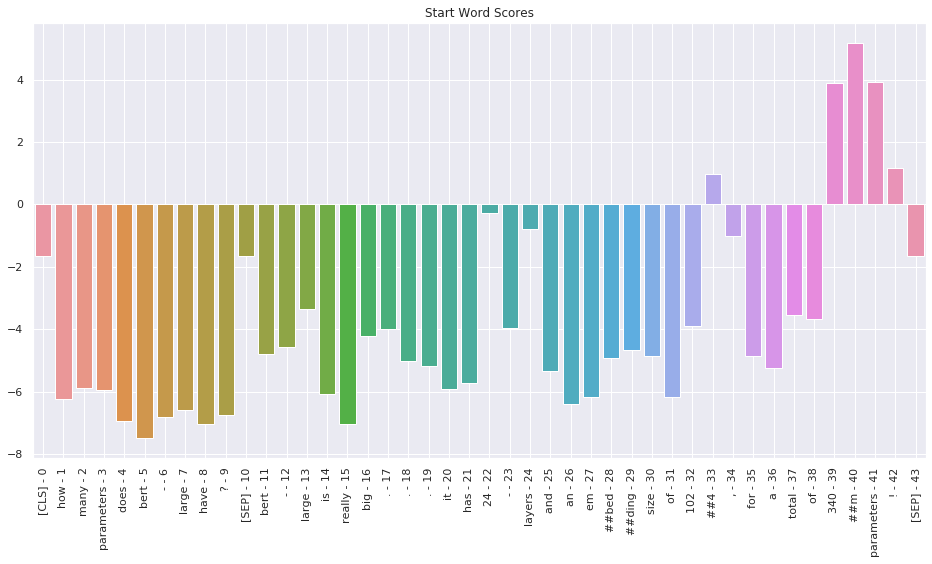

In [29]:

ax = sns.barplot(x=token_labels, y=e_scores, ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
ax.grid(True)
plt.title("Start Word Scores")
plt.show

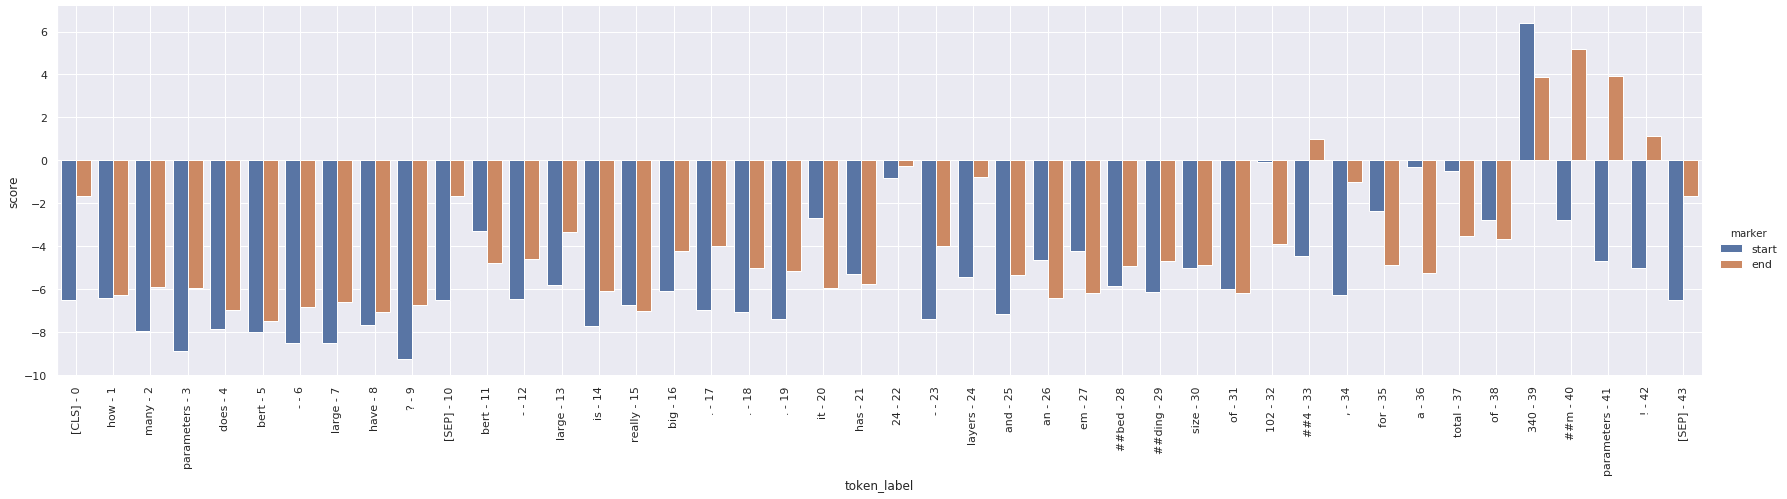

In [30]:
import pandas as pd

scores = []
for (i, token_label) in enumerate(token_labels):
    scores.append({
        "token_label": token_label,
        "score": s_scores[i],
        "marker": 'start'
    })
    scores.append({
        "token_label": token_label,
        "score": e_scores[i],
        "marker": 'end'
    })
df = pd.DataFrame(scores)

g = sns.catplot(x='token_label',
                y='score',
                hue='marker',
                data=df,
                kind='bar',
                height=6,
                aspect=4)

g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha='center')

g.ax.grid(True)

# 总结

## `BERT` 是怎么用 `Transformer` 的？

- `BERT_BASE:L=12,H=768,A=12`:层的数量为 `L`，隐藏层的维度为 `H`，自注意头的个数为 `A`，前馈过滤器的维度为 `4H`        
- `BERT` 的输入向量表示，比 `Transformer` 多了 `Segment Embeddings`

### `ELMo` 和 `BERT `
- 从网络结构以及最后的实验效果来看，`BERT` 比 `ELMo` 效果好主要集中在以下几点原因：
    - `LSTM` 抽取特征的能力远弱于 `Transformer`
    - `BERT` 的训练数据以及模型参数均多余 `ELMo`，这也是比较重要的一点
    
       
- `ELMo` 和 `BERT` 的区别是什么？
    - `ELMo` 模型是通过语言模型任务得到句子中单词的 `embedding` 表示，以此作为补充的新特征给下游任务使用。这一类预训练的方法被称为 `Feature-based Pre-Training`。
    - `BERT` 模型是“基于 `Fine-tuning` 的模式”，这种做法和图像领域基于 `Fine-tuning` 的方式基本一致，下游任务需要将模型改造成 `BERT` 模型，才可利用 `BERT` 模型预训练好的参数。    
    

### BERT 的输入和输出
- 最底层输入是文本中各个字/词(`token`)的原始词向量，该向量既可以随机初始化，也可以利用 `Word2Vector` 等算法进行预训练以作为初始值
    - 英文词汇被进一步切割，划分为更细粒度的 WordPiece，而不是常见的单词
    - 中文语料是直接划分成单字
- 除此之外还包含文本向量(`Segment Embeddings`)，该向量的取值在模型训练过程中自动学习，用于刻画文本的全局语义信息，并与单字/词的语义信息相融合
- 位置向量(`Position Embeddings`)：由于出现在文本不同位置的字/词所携带的语义信息存在差异（比如：“我爱你”和“你爱我”），因此，BERT 模型对不同位置的字/词分别附加一个不同的向量以作区分
- 三者加和作为模型输入
- 输出是文本中各个字/词融合了全文语义信息后的向量表示

- 在做 `Next Sentence Prediction` 任务时，在第一个句子的首部会加上一个`[CLS] token`，在两个句子中间以及最后一个句子的尾部会加上一个`[SEP] token`

## 如何用 `BERT` 结构怎么做 `fine-tuning`


### 多标签分类（不同于多类别）
- 输入通过得到 `embedding` 表示之后，再并行连接 `n` 个全连接层，再分别接上 `softmax` 分类；每个全连接层对一个标签分类

TODO

# `Transformers`模块中`BERT`的简单运用

In [ ]:
import torch
from transformers import BertModel, BertTokenizer

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

input_text = "Here is some text to encode"
input_ids = tokenizer.encode(input_text)
input_ids = torch.tensor([input_ids])

with torch.no_grad():
    last_hidden_states = model(input_ids)[0]

# `BERT`模型
- `BERT`代表`Bidirectional Encoder Representations from Transformers`，BERT模型的主要结构是`Transformer`的编码器
- `BERT`是基于大量无标签文本(`Wikipedia-2500M单词+书籍-800M单词`)进行预训练的
    - 预训练步骤是`BERT`成功的主要原因，在大量语料上进行训练后，模型开始“理解”语言
- BERT是“深度双向”模型，训练时从一个token的左右两边学习信息
![](images/bert-bidirectional.png)
    - 如上图中的单词`bank`，基于其左边和右边不同的信息，有不同的涵义
- 通过在`BERT`的预训练模型上添加上一些额外的输出层进行优调，可以很好的用于一些列`NLP`任务

### `BERT`输入
![](images/bert-input.png)

1. `Position Embeddings`：两个句子，“武汉到广州的车票”与“广州到武汉的车票”，`self-attention`是不考虑`token`在句子中的位置，因此无法区别这两句话；因此引入位置编码，句子中的每个位置都有一个独特的位置编码
2. `Segment Embeddings`：预训练任务`NSP`，输入文本是句子对，需要预测两句话是否是连续的两句话，因此添加句子编码
3. `Token Embeddings`：每个`token`的词表征

### `BERT`预训练任务
![](images/bert-tasks.png)